<h1 div class='alert alert-success'><center> Feature Engineering </center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  OBJETIVO </div> 

O objetivo neste notebook é criação novas variáveis (feature) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook]() de 0.94297 com XGBoost utilizando scaler MaxAbsScaler  e **n_estimators** com 1000.

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [1]:
! pip install --q scikit-plot

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [3]:
import warnings
import random
import os
import gc
import torch
import math
import sklearn.exceptions

In [4]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scikitplot        as skplt

In [5]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder, normalize
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from datetime                import datetime
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

In [6]:
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.utils.class_weight import compute_sample_weight
from scipy                      import stats
from scipy.cluster              import hierarchy as hc
from math                       import factorial
from scipy.stats                import mode

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [7]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [8]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [9]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [10]:
def scaler_MaxAbsScaler_StandardScaler(df):    
    sc_mm = MaxAbsScaler()
    sc_st = StandardScaler()     
    col = df.columns
    df  = sc_mm.fit_transform(df)
    df  = pd.DataFrame(sc_st.fit_transform(df), columns=col)    
    return df

In [11]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [12]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

## 1.4. Criar estrutura de pasta 


In [13]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'model/mdl/',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param']

for path in paths:
    try:
        os.mkdir(path)
    except:
        pass  

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [14]:
path      = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/02 - Fevereiro/'
path      = '../input/tabular-playground-series-feb-2022/'
path_data = '' 
target    = 'target'

In [15]:
df1_train     = pd.read_csv(path + path_data + 'train.csv')
df1_test      = pd.read_csv(path + path_data + 'test.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((200000, 288), (100000, 287), (100000, 2))

### 1.5.3. Visualizar os dados 

In [16]:
df1_train.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,-9.536743e-07,-0.000010,-8.583069e-05,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.000010,-4.291534e-05,-0.000343,-0.001202,-0.002403,-0.003004,-0.002403,-0.001202,-0.000343,-0.000043,-0.000114,-0.000801,-0.002403,-0.004005,-0.004005,-0.002403,-0.000801,-0.000114,-0.000200,-0.001202,-0.003004,-0.004005,-0.003004,-0.001202,-0.000200,-0.000240,-0.001202,-0.002403,-0.002403,-0.001202,-0.000240,-0.000200,-0.000801,-0.001202,-0.000801,-0.000200,-0.000114,-0.000343,-0.000343,-0.000114,-0.000043,-0.000086,-0.000043,-0.000010,-0.000010,-9.536743e-07,-9.536743e-06,-0.000086,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.000010,-0.000086,-0.000687,-0.002403,-0.004807,-0.006008,-0.004807,-0.002403,-0.000687,-0.000086,-0.000343,-0.002403,-0.007210,-0.002016,-0.012016,-0.007210,0.017597,0.009657,-0.000801,-0.004807,0.007984,-0.006022,0.007984,-0.004807,-0.000801,-0.001202,0.003992,-0.012016,-0.012016,0.003992,0.008798,-0.001202,-0.004807,0.002790,-0.004807,-0.001202,-0.000801,0.007597,0.007597,-0.000801,-0.000343,-0.000687,-0.000343,-0.000086,-0.000086,-0.000010,-0.000043,-0.000343,-0.001202,-0.002403,-0.003004,-0.002403,-0.001202,-0.000343,-0.000043,-0.000343,-0.002403,-0.007210,-0.012016,-0.002016,-0.007210,-0.002403,-0.000343,0.008798,

In [17]:
df1_test.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,-0.000008,-9.536743e-07,-0.000003,-0.000017,-0.000074,0.000038,0.000068,0.000164,0.000180,-0.000003,-0.000025,-0.000009,0.000004,-0.000101,-0.000171,0.000006,0.000330,0.000580,0.000228,-0.000015,-0.000016,-0.000026,-0.000146,-0.000075,0.000212,0.000565,0.000359,0.000072,-0.000005,-0.000043,-0.000110,0.000061,0.000349,0.000338,0.000163,-0.000003,0.000005,0.000050,0.000332,0.000447,0.000212,0.000016,0.000031,0.000196,0.000331,0.000261,0.000035,0.000064,0.000202,0.000175,0.000047,0.000031,0.000104,0.000026,0.000012,0.000009,-9.536743e-07,4.632568e-07,-0.000016,-0.000005,0.000141,0.000170,0.000091,0.000076,-0.000062,-0.000026,-0.000005,-0.000019,-0.000179,-0.000068,0.000362,0.000505,0.000449,-0.000047,-0.000148,-0.000027,-0.000092,-0.000457,-0.000095,0.000379,0.000940,0.000355,-0.000236,-0.000087,-0.000180,-0.000496,-0.000106,0.000351,0.000539,-0.000045,-0.000107,-0.000103,-0.000306,0.000241,0.000404,0.000074,-0.000065,0.000071,0.000282,0.000549,0.000418,0.000001,0.000214,0.000584,0.000592,0.000200,0.000193,0.000354,0.000146,0.000102,0.000091,0.000024,-0.000011,-0.000030,0.000263,0.000496,0.000333,0.000038,-0.000180,-0.000093,-0.000009,-0.000086,-0.000142,0.000172,0.000703,0.000237,-0.000323,-0.000412,-0.000083,-0.000231,-0.000618,-0.000275,-0.000510,-0.000272,-0.000569,-0.000264,-0.000420,-0.0

# <div class="alert alert-success"> 2. PROCESSAMENTO </div> 

In [18]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()
df2_train.shape, df2_test.shape

((200000, 288), (100000, 287))

## 2.1. Excluir variáveis

In [19]:
df2_train.drop('row_id', axis=1, inplace=True)
df2_test.drop('row_id', axis=1, inplace=True)

In [20]:
features = df2_train.columns[df2_train.columns!=target]

## 2.2. Duplicados 
referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants

In [21]:
df2_train.duplicated().sum()

76007

In [22]:
vc = df2_train.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df2_train.columns)
dedup_train['sample_weight'] = vc.values
dedup_train.shape

(123993, 288)

In [23]:
(df2_train[features].values == dedup_train[features].iloc[0].values.reshape(1, -1)).all(axis=1).sum()

18

In [24]:
df2_train = dedup_train.copy()

## 2.3. Redução dos datasets

In [25]:
df2_train = reduce_memory_usage(df2_train)
df2_test  = reduce_memory_usage(df2_test)

Mem. usage decreased to 68.70 Mb (74.8% reduction)
Mem. usage decreased to 54.55 Mb (75.0% reduction)


In [26]:
df2_train.shape, df2_test.shape

((123993, 288), (100000, 286))

# <div class="alert alert-success"> 3. FEATURE ENGINEERING </div> 
Nesta parte do processo vamos criar diversas variávies com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial **fe_**, a cada criação de novas variáveis vamos treinar o modelo __XGBoost__ e identificar se as novas variáveis ajudam a encontrar novos padrões.

## 3.1. Feature Descritivas 
Nesta etapa vamos criar novar variárias com medidas estatísticas.

In [27]:
feature_float = df2_test.select_dtypes(np.number).columns

In [28]:
def feature_statistic(df, feature_float, feature_cat=None):
    
    df['fe_mean']         = df[feature_float].mean(axis=1)   
    df['fe_std']          = df[feature_float].std(axis=1)   
    df['fe_median']       = df[feature_float].median(axis=1)   
    df['fe_var']          = df[feature_float].var(axis=1) 
    df['fe_min']          = df[feature_float].min(axis=1)   
    df['fe_max']          = df[feature_float].max(axis=1)      
    df['fe_skew']         = df[feature_float].skew(axis=1)   
    df['fe_kurt']         = df[feature_float].kurt(axis=1)
    df['fe_quantile_25']  = df[feature_float].quantile(q=.25, axis=1)
    df['fe_quantile_50']  = df[feature_float].quantile(q=.5, axis=1)
    df['fe_quantile_75']  = df[feature_float].quantile(q=.75, axis=1)
    
    df['fe_range']        = df['fe_max'] - df['fe_min']
    df['fe_iqr']          = df['fe_quantile_75'] - df['fe_quantile_25']    
    df['fe_tails']        = df['fe_range'] / df['fe_iqr']    
    df['fe_dispersion_1'] = df['fe_median'] / df['fe_iqr']   
        
    if feature_cat is not None:
        df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(999, inplace=True)
    
    df = reduce_memory_usage (df, verbose=False)

    return df.dropna(axis=1)

In [29]:
feature_new = list(df2_train.columns)

In [30]:
df3_1_train = feature_statistic(df2_train.copy(), feature_new)  
df3_1_test  = feature_statistic(df2_test.copy(), feature_float)

df3_1_train.shape, df3_1_test.shape

((123993, 303), (100000, 301))

In [31]:
df3_1_train.filter(regex=r'fe').head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fe_mean          5 non-null      float16
 1   fe_std           5 non-null      float16
 2   fe_median        5 non-null      float16
 3   fe_var           5 non-null      float16
 4   fe_min           5 non-null      float16
 5   fe_max           5 non-null      float16
 6   fe_skew          5 non-null      float16
 7   fe_kurt          5 non-null      float16
 8   fe_quantile_25   5 non-null      float16
 9   fe_quantile_50   5 non-null      float16
 10  fe_quantile_75   5 non-null      float16
 11  fe_range         5 non-null      float16
 12  fe_iqr           5 non-null      float16
 13  fe_tails         5 non-null      float16
 14  fe_dispersion_1  5 non-null      float16
dtypes: float16(15)
memory usage: 278.0 bytes


## 3.1.1. Modelagem

In [32]:
lb     = LabelEncoder()
X      = df3_1_train.drop([target], axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_1_train[target]), columns=[target])
X_test = df3_1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

sample_weight_train = X_train['sample_weight']
sample_weight_valid = X_valid['sample_weight']

X_train.drop('sample_weight', axis=1, inplace=True)
X_valid.drop('sample_weight', axis=1, inplace=True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((99194, 301), (99194, 1), (24799, 301), (24799, 1), (100000, 301))

In [33]:
%%time

seed   = 12359
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',         
          'n_estimators'  : 1000,
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

scaler     = RobustScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train) , columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test_sc  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = xgb.XGBClassifier(**params)
model.fit(X_train_sc, y_train, sample_weight_train)

y_pred      = model.predict(X_valid_sc)
y_pred_test = model.predict(X_test_sc)

acc = metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weight_valid)

print ('ACC: {:2.5f}'.format(acc), end='\n\n')

ACC: 0.95284

CPU times: user 1min 27s, sys: 829 ms, total: 1min 28s
Wall time: 1min 29s


### 3.1.2. Feature Importances  

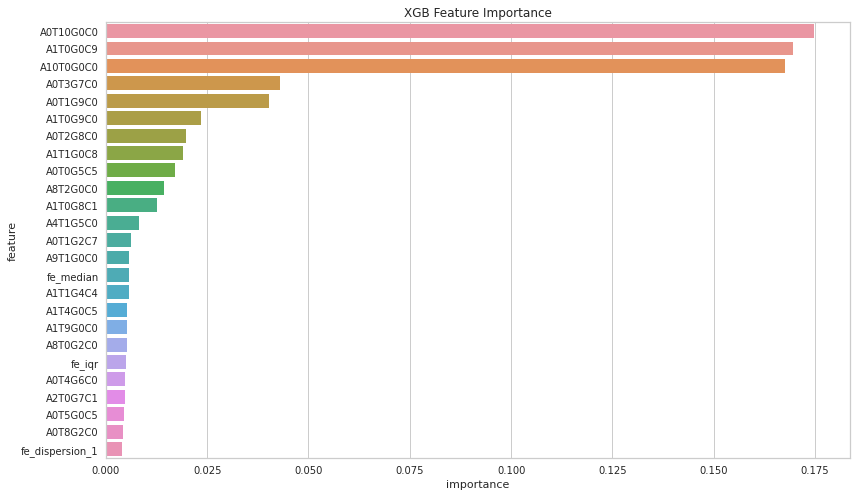

In [34]:
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})

plt.figure(figsize=(12, 7))
sns.barplot(x="importance", 
            y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:25])

plt.title("XGB Feature Importance")
plt.tight_layout()

plt.show()

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Podemos observar acima no gráfico de importância das variáveis, que temos 3 variáveis que criamos entre as 25 primeiras variáveis, vamos fazer uma validação cruzada e armazenar a importância das variáveis em cada fold, para termos uma ideia de como essas variáveis se comportam. 
    
</div>

### 3.1.2. Validação cruzada

In [35]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, seed_, level_='1', target_='target'):    
    
    level = 'n' + level_ + '/'

    if score_>.6:    
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)

In [36]:
def model_train_cv_fit(model_, X_, y_, X_test_, lb_, target_, model_name_, sc_=MinMaxScaler(), sc_second_=None, 
                       n_splits_=5, seed_=12359, save_sub_=True, path_='', save_predict_=False, level_='1'):
    
    taco              = 76 
    y_preds_test      = []
    y_preds_val_prob  = [] 
    y_preds_test_prob = []
    score             = []
    mdl               = []
    col_prob          = y_[target_].sort_values().unique()
    df_preds_prob     = pd.DataFrame()
    df_feature_imp    = pd.DataFrame()
    time_start        = datetime.now()    
    n_estimators      = model_.get_params()['n_estimators']
    dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''
    
    print('='*taco)
    print('Scaler: {} - n_estimators: {} {}'.format(sc, n_estimators, dub_scaler))
    print('='*taco)

    folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

    for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y)):

        time_fold_start = datetime.now()
        
        # ----------------------------------------------------
        # Separar dados para treino 
        # ----------------------------------------------------
        X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
        y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 
                
        # ----------------------------------------------------
        # Processamento
        # ----------------------------------------------------        
        X_trn.drop('sample_weight', axis=1, inplace=True)
        X_val.drop('sample_weight', axis=1, inplace=True)
        
        X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
        X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
        X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

        if sc_second_ is not None: 
            X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)
                        
        # ---------------------------------------------------- 
        # Treinar o modelo 
        # ----------------------------------------------------     
        model_.fit(X_trn, 
                   y_trn,
                   sample_weight_train,
                   eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                   early_stopping_rounds = int(n_estimators*.1),
                   verbose               = False)

        # ---------------------------------------------------- 
        # Predição 
        # ----------------------------------------------------     
        y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
        y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
        y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)
        
        y_preds_test.append(model_.predict(X_tst))
        y_preds_test_prob.append(y_pred_test_prob)
       
        df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
        y_pred_pbro_max = df_prob_temp.max(axis=1)

        df_prob_temp['fold']    = fold+1
        df_prob_temp['id']      = val_idx        
        df_prob_temp['y_val']   = y_val.values
        df_prob_temp['y_pred']  = y_pred_val            
        df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
        
        df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)
        
        # ---------------------------------------------------- 
        # Score 
        # ---------------------------------------------------- 
        acc   = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
        f1    = metrics.f1_score(y_val, y_pred_val, average='macro') # weighted
        prec  = metrics.precision_score(y_val, y_pred_val, average='macro')

        score.append(acc)     

        # ---------------------------------------------------- 
        # Print resultado  
        # ---------------------------------------------------- 
        time_fold_end = diff(time_fold_start, datetime.now())
        msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
        print(msg.format(fold+1, acc, f1, prec, time_fold_end))

        # ---------------------------------------------------- 
        # Feature Importance
        # ----------------------------------------------------             
        feat_imp = pd.DataFrame(index   = X_trn.columns,
                                data    = model_.feature_importances_,                            
                                columns = ['fold_{}'.format(fold+1)])

        feat_imp['acc_'+str(fold+1)] = acc
        df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

        # ---------------------------------------------------- 
        # Salvar o modelo 
        # ---------------------------------------------------- 
        dic_model = {'scaler': sc, 'scaler_second': sc_second_,'fold': fold+1,'model': model_}
        mdl.append(dic_model)

        time_end = diff(time_start, datetime.now())   

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

    df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

    # ------------------------------
    # Pós-processamento
    # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
    # -------------------------------        
    y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
    y_proba += np.array([0, 0, 0.01, 0.03, 0, 0, 0, 0, 0, 0])  
    
    y_pred_tuned      = lb.inverse_transform(np.argmax(y_proba, axis=1))
    y_pred_tuned_prob = np.max(y_proba, axis=1)

    if save_predict_:                 
        save_data_model(model_             = mdl, 
                        model_name_        = model_name_ +'_'+str(sc_second_).lower()[:4], 
                        path_              = path_, 
                        y_pred_train_prob_ = df_preds_prob['y_proba'], 
                        y_pred_test_prob_  = y_pred_tuned_prob, 
                        y_pred_test_       = y_pred_tuned,
                        score_             = acc_mean, 
                        seed_              = seed_, 
                        level_             = level_, 
                        target_            = target_
                        ) 

    print('-'*taco)
    print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
    print('='*taco)
    print()

    if save_sub_:         
        df_submission[target_] = y_pred_tuned        
        name_file_sub          = model_name_ +'_'+str(sc_second_).lower()[:4]+'.csv'
        df_submission.to_csv(path_+'Data/submission/'+name_file_sub.format(acc_mean), index=False)
        
    del X_trn, X_val, y_trn, y_val, feat_imp

    return mdl, df_feature_imp, df_feature_imp , df_preds_prob

In [37]:
lb     = LabelEncoder()
X      = df3_1_train.drop([target], axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_1_train[target]), columns=[target])
X_test = df3_1_test

In [38]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',   
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_01_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)

    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.95246 - F1-macro: 0.97425 - Precision: 0.97427  - 0h 0m 49s
[Fold 2] ACC: 0.95501 - F1-macro: 0.97490 - Precision: 0.97493  - 0h 0m 57s
[Fold 3] ACC: 0.95049 - F1-macro: 0.97309 - Precision: 0.97311  - 0h 0m 56s
[Fold 4] ACC: 0.95229 - F1-macro: 0.97406 - Precision: 0.97409  - 0h 0m 56s
[Fold 5] ACC: 0.95214 - F1-macro: 0.97370 - Precision: 0.97374  - 0h 0m 59s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.95248 std: 0.00145 - 0h 4m 39s

CPU times: user 4min 47s, sys: 4.31 s, total: 4min 51s
Wall time: 4min 41s




### 3.1.3. Feature Importances  CV 

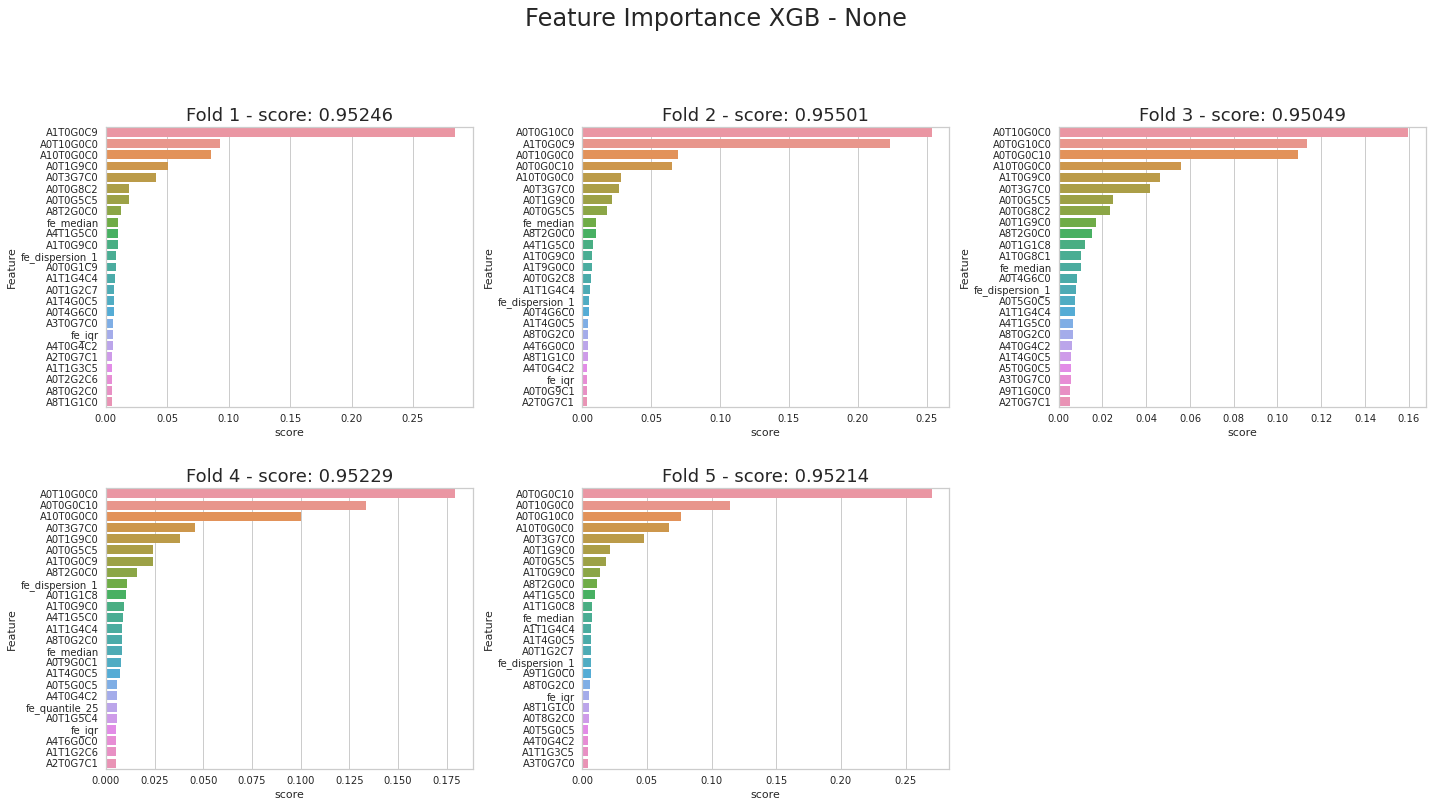

In [39]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,15))
    row = int(np.round(df_trn_mdl[i].filter(regex=r'fold').shape[1] / 3 +1))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(row,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.2. Agregar valores ATGC individuais
referencia: 

In [40]:
def feature_aggregate_ATGC(df, cols):
    A = np.zeros(len(cols))
    T = np.zeros(len(cols))
    G = np.zeros(len(cols))
    C = np.zeros(len(cols))

    for i, x in enumerate(cols):
        A[i] = int(x.split('A')[1].split('T')[0])
        T[i] = int(x.split('T')[1].split('G')[0])
        G[i] = int(x.split('G')[1].split('C')[0])
        C[i] = int(x.split('C')[1])

    A /= 10
    T /= 10
    G /= 10
    C /= 10

    df['fe_A'] = np.matmul(df[cols].to_numpy(), A[np.newaxis].T) 
    df['fe_T'] = np.matmul(df[cols].to_numpy(), T[np.newaxis].T) 
    df['fe_G'] = np.matmul(df[cols].to_numpy(), G[np.newaxis].T) 
    df['fe_C'] = np.matmul(df[cols].to_numpy(), C[np.newaxis].T) 

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(999, inplace=True)
    
    df = reduce_memory_usage (df, verbose=False)

    return df

In [41]:
df3_2_train = feature_aggregate_ATGC(df3_1_train.copy(),feature_float)
df3_2_test  = feature_aggregate_ATGC(df3_1_test.copy(), feature_float)

df3_2_train.shape, df3_2_train.shape

((123993, 307), (123993, 307))

In [42]:
df3_2_train.filter(regex=r'fe').head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fe_mean          5 non-null      float16
 1   fe_std           5 non-null      float16
 2   fe_median        5 non-null      float16
 3   fe_var           5 non-null      float16
 4   fe_min           5 non-null      float16
 5   fe_max           5 non-null      float16
 6   fe_skew          5 non-null      float16
 7   fe_kurt          5 non-null      float16
 8   fe_quantile_25   5 non-null      float16
 9   fe_quantile_50   5 non-null      float16
 10  fe_quantile_75   5 non-null      float16
 11  fe_range         5 non-null      float16
 12  fe_iqr           5 non-null      float16
 13  fe_tails         5 non-null      float16
 14  fe_dispersion_1  5 non-null      float16
 15  fe_A             5 non-null      float16
 16  fe_T             5 non-null      float16
 17  fe_G             5 n

### 3.2.1. Modelagem

In [43]:
lb     = LabelEncoder()
X      = df3_2_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_1_train[target]), columns=[target])
X_test = df3_2_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)
sample_weight_train = X_train['sample_weight']
sample_weight_valid = X_valid['sample_weight']

X_train.drop('sample_weight', axis=1, inplace=True)
X_valid.drop('sample_weight', axis=1, inplace=True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((99194, 305), (99194, 1), (24799, 305), (24799, 1), (100000, 305))

In [44]:
%%time

seed   = 12359
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',   
          'n_estimators'  : 1000,
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

scaler     = RobustScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train) , columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

model = xgb.XGBClassifier(**params)
model.fit(X_train_sc, y_train, sample_weight_train)

y_pred = model.predict(X_valid_sc)

acc = metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weight_valid)

print ('ACC: {:2.5f}'.format(acc), end='\n\n')
# ACC: 0.97355

ACC: 0.95180

CPU times: user 1min 22s, sys: 344 ms, total: 1min 22s
Wall time: 1min 22s


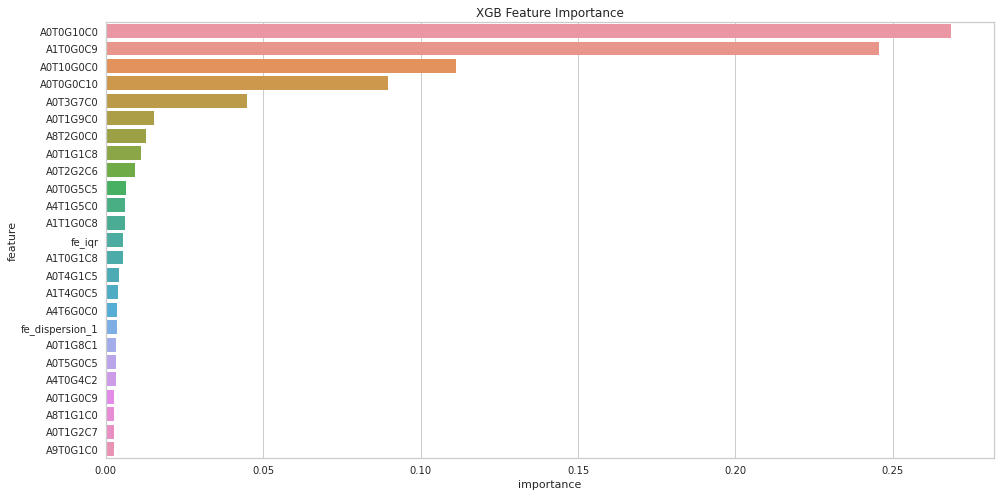

In [45]:
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", 
            y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:25])

plt.title("XGB Feature Importance")
plt.tight_layout()

plt.show()

### 3.2.2. Validação cruzada

In [46]:
lb     = LabelEncoder()
X      = df3_2_train.drop([target], axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_2_train[target]), columns=[target])
X_test = df3_2_test

In [47]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',      
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_02_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.95084 - F1-macro: 0.97254 - Precision: 0.97257  - 0h 0m 49s
[Fold 2] ACC: 0.95464 - F1-macro: 0.97416 - Precision: 0.97419  - 0h 0m 49s
[Fold 3] ACC: 0.95042 - F1-macro: 0.97272 - Precision: 0.97272  - 0h 0m 52s
[Fold 4] ACC: 0.95000 - F1-macro: 0.97308 - Precision: 0.97310  - 0h 0m 49s
[Fold 5] ACC: 0.94992 - F1-macro: 0.97216 - Precision: 0.97218  - 0h 0m 47s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.95116 std: 0.00177 - 0h 4m 9s

CPU times: user 4min 15s, sys: 4.47 s, total: 4min 20s
Wall time: 4min 10s


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Como podemos observar acima, tivemos um aumento no score, isso é um indicativo que as novas variáveis estão ajudando na predições.
    
</div>

### 3.2.3. Feature Importances  CV 

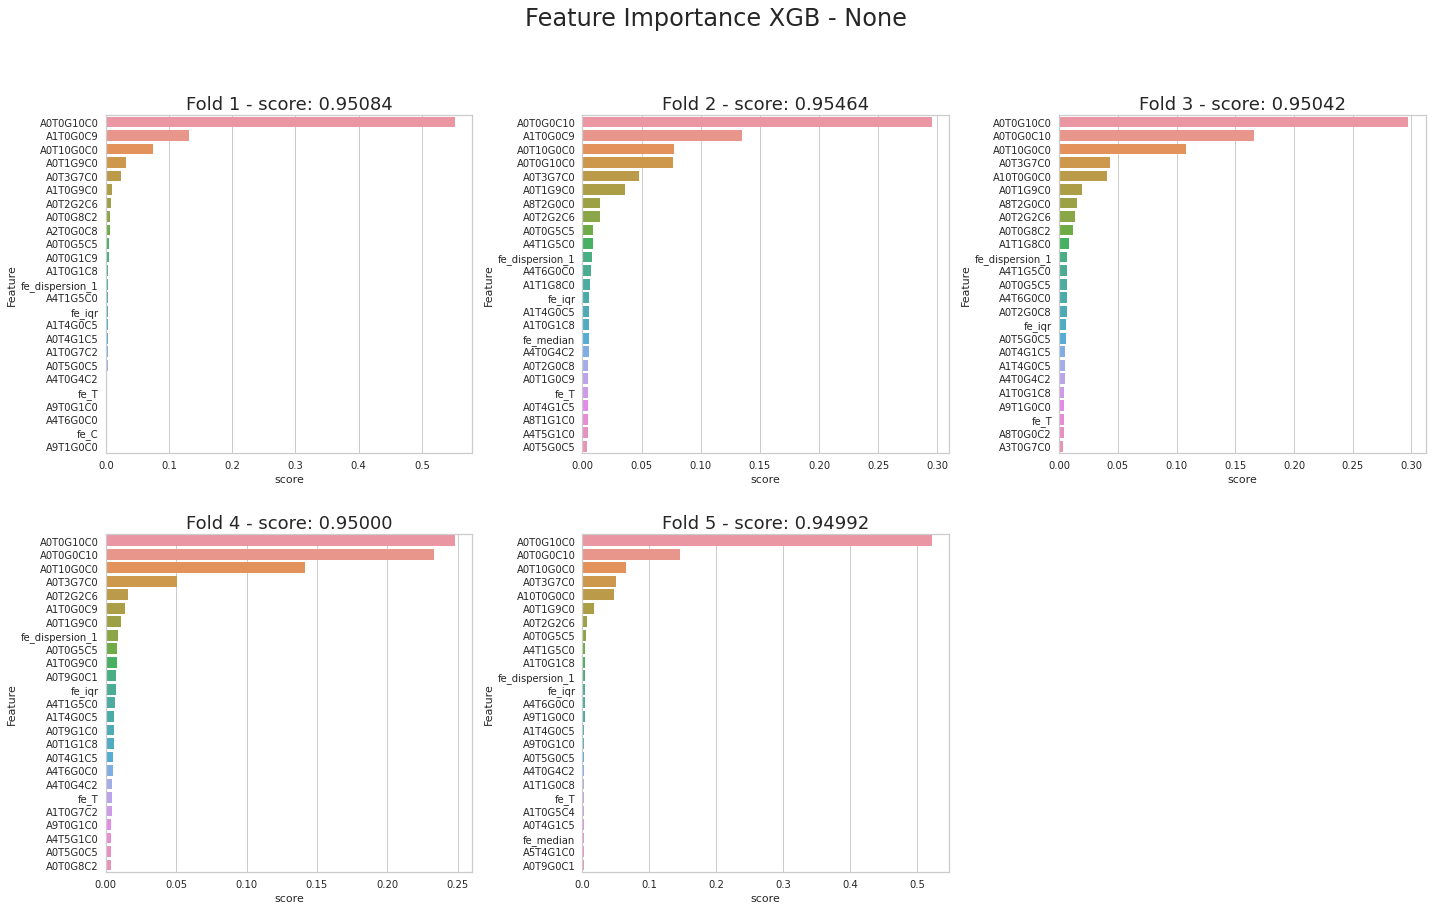

In [48]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.3. Adicionando decâmeros

Conforme explicado na EDA do @AMBROSM, há um número diferente de decâmeros na amostra devido ao processo descrito no artigo "Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers" (https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full). Queremos adicionar também este recurso para testar se é informativo.

Consulte este notebook https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense para obter o código original e vote-o se achar útil.

In [49]:
df3_3_train = df3_2_train.copy()
df3_3_test  = df3_2_test.copy()

In [50]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def gcd_of_all(df_i, elements=feature_float):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

In [51]:
train_i = pd.DataFrame({col: ((df3_3_train[col]+bias_of(col))*1000000).round().astype(int) for col in feature_float})
test_i  = pd.DataFrame({col: ((df3_3_test[col]+bias_of(col))*1000000).round().astype(int) for col in feature_float})

df3_3_train['fe_gcd'] = gcd_of_all(train_i)
df3_3_test['fe_gcd']  = gcd_of_all(test_i)

del([train_i, test_i])

In [52]:
df3_3_train.filter(regex=r'fe').head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fe_mean          5 non-null      float16
 1   fe_std           5 non-null      float16
 2   fe_median        5 non-null      float16
 3   fe_var           5 non-null      float16
 4   fe_min           5 non-null      float16
 5   fe_max           5 non-null      float16
 6   fe_skew          5 non-null      float16
 7   fe_kurt          5 non-null      float16
 8   fe_quantile_25   5 non-null      float16
 9   fe_quantile_50   5 non-null      float16
 10  fe_quantile_75   5 non-null      float16
 11  fe_range         5 non-null      float16
 12  fe_iqr           5 non-null      float16
 13  fe_tails         5 non-null      float16
 14  fe_dispersion_1  5 non-null      float16
 15  fe_A             5 non-null      float16
 16  fe_T             5 non-null      float16
 17  fe_G             5 n

## 3.3.1. Modelagem

In [53]:
lb     = LabelEncoder()
X      = df3_3_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_3_train[target]), columns=[target])
X_test = df3_3_test

### 3.3.2. Validação cruzada

In [54]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',   
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_03_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.95051 - F1-macro: 0.97287 - Precision: 0.97288  - 0h 0m 45s
[Fold 2] ACC: 0.95124 - F1-macro: 0.97288 - Precision: 0.97290  - 0h 0m 48s
[Fold 3] ACC: 0.94992 - F1-macro: 0.97260 - Precision: 0.97261  - 0h 0m 50s
[Fold 4] ACC: 0.94864 - F1-macro: 0.97203 - Precision: 0.97203  - 0h 0m 47s
[Fold 5] ACC: 0.94977 - F1-macro: 0.97231 - Precision: 0.97233  - 0h 0m 43s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.95002 std: 0.00086 - 0h 3m 55s

CPU times: user 4min 5s, sys: 5.14 s, total: 4min 10s
Wall time: 3min 56s


### 3.3.3. Feature Importances  CV 

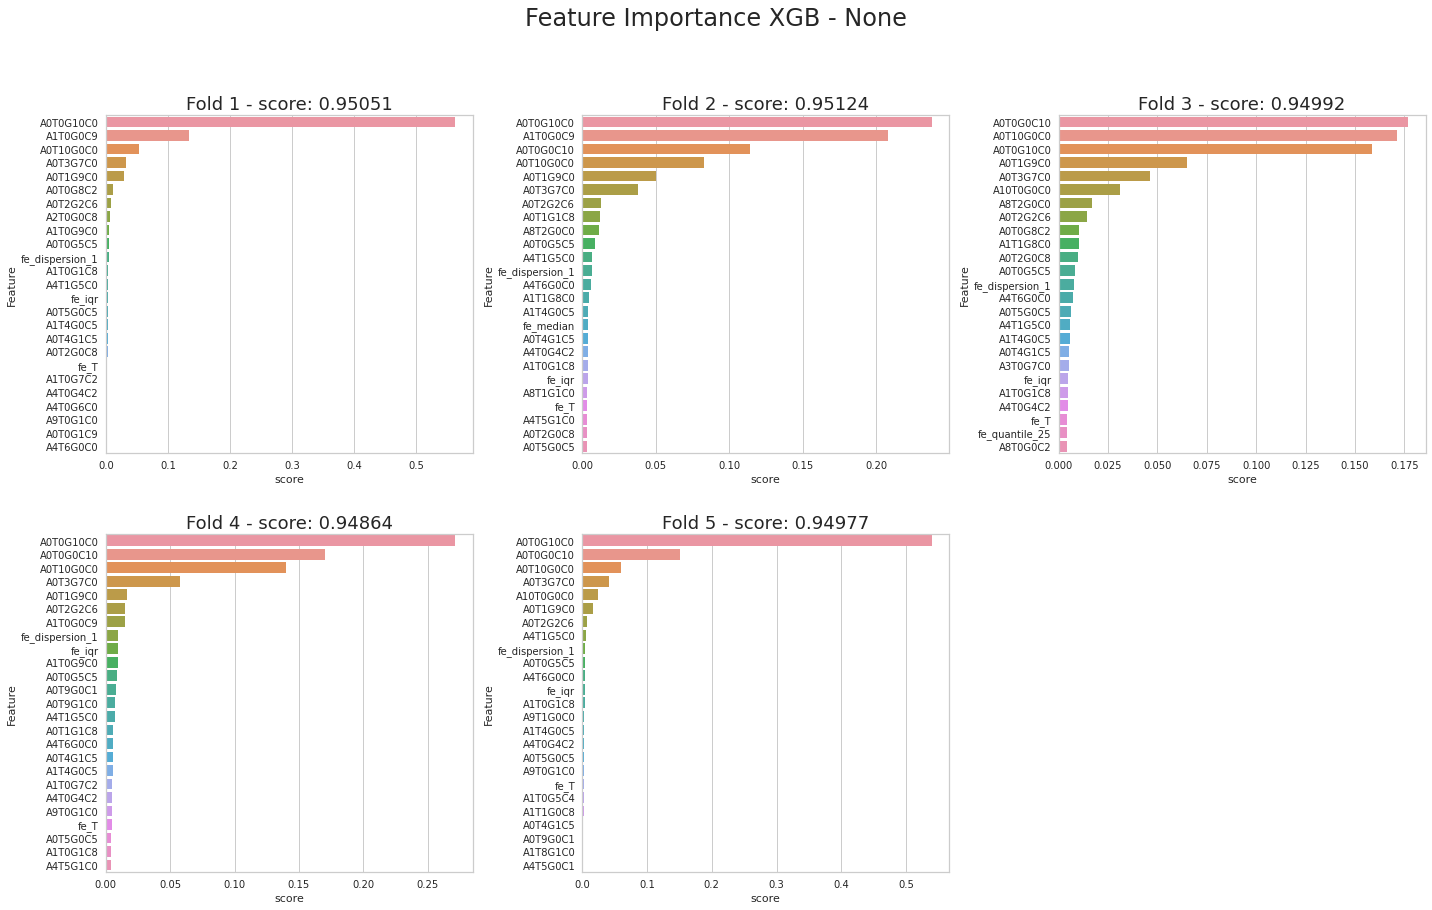

In [55]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.4. Gerar PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis para os modelos.


In [56]:
df3_4_train = df3_3_train.copy()
df3_4_test  = df3_3_test.copy()

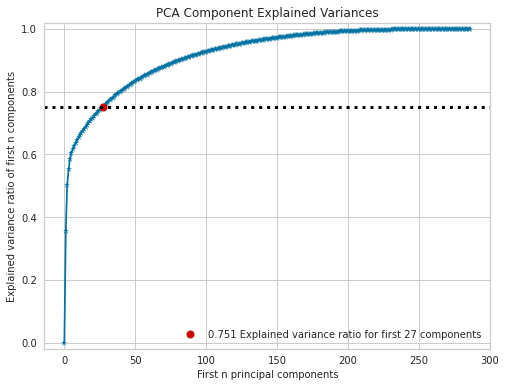

In [57]:
feature_pca     = feature_float
pca             = PCA(random_state=12359)
df3_4_train_pca = pca.fit_transform(df3_4_train[feature_pca])

skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));

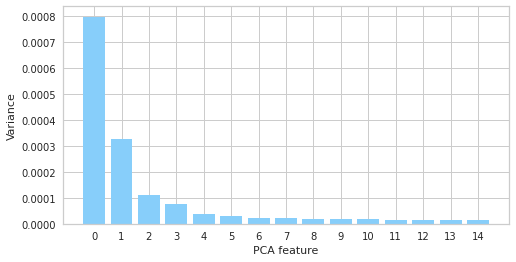

In [58]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Como podemos observar acima, o processo de PCA 27 componentes que repesentam 75% da variabilidade dos dados, sendo que vamos utilizar apenas as duas primeiras componentes, isso é, vamos cria duas novas variáveis. 
    
</div>

In [59]:
n_components  = 4
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]

df3_4_train[pca_feats] = pd.DataFrame(pca.fit_transform(df3_4_train[feature_float]), columns=pca_feats)
df3_4_test[pca_feats]  = pd.DataFrame(pca.transform(df3_4_test[feature_float]), columns=pca_feats)

In [60]:
df3_4_train.filter(regex=r'fe').head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fe_mean          5 non-null      float16
 1   fe_std           5 non-null      float16
 2   fe_median        5 non-null      float16
 3   fe_var           5 non-null      float16
 4   fe_min           5 non-null      float16
 5   fe_max           5 non-null      float16
 6   fe_skew          5 non-null      float16
 7   fe_kurt          5 non-null      float16
 8   fe_quantile_25   5 non-null      float16
 9   fe_quantile_50   5 non-null      float16
 10  fe_quantile_75   5 non-null      float16
 11  fe_range         5 non-null      float16
 12  fe_iqr           5 non-null      float16
 13  fe_tails         5 non-null      float16
 14  fe_dispersion_1  5 non-null      float16
 15  fe_A             5 non-null      float16
 16  fe_T             5 non-null      float16
 17  fe_G             5 n

## 3.4.1. Modelagem

In [61]:
lb     = LabelEncoder()
X      = df3_4_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df3_4_train[target]), columns=[target])
X_test = df3_4_test

### 3.4.2. Validação cruzada

In [62]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',  
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_04_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                       save_predict_ = True)
    
    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.94968 - F1-macro: 0.97254 - Precision: 0.97256  - 0h 0m 46s
[Fold 2] ACC: 0.95171 - F1-macro: 0.97283 - Precision: 0.97285  - 0h 0m 50s
[Fold 3] ACC: 0.95004 - F1-macro: 0.97248 - Precision: 0.97250  - 0h 0m 46s
[Fold 4] ACC: 0.94882 - F1-macro: 0.97244 - Precision: 0.97246  - 0h 0m 47s
[Fold 5] ACC: 0.95079 - F1-macro: 0.97192 - Precision: 0.97196  - 0h 0m 45s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.95021 std: 0.00098 - 0h 3m 56s

CPU times: user 4min 5s, sys: 5.43 s, total: 4min 11s
Wall time: 3min 57s


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>
Tivemos um pequeno aumento com a criação das duas variaveis.  
    
</div>

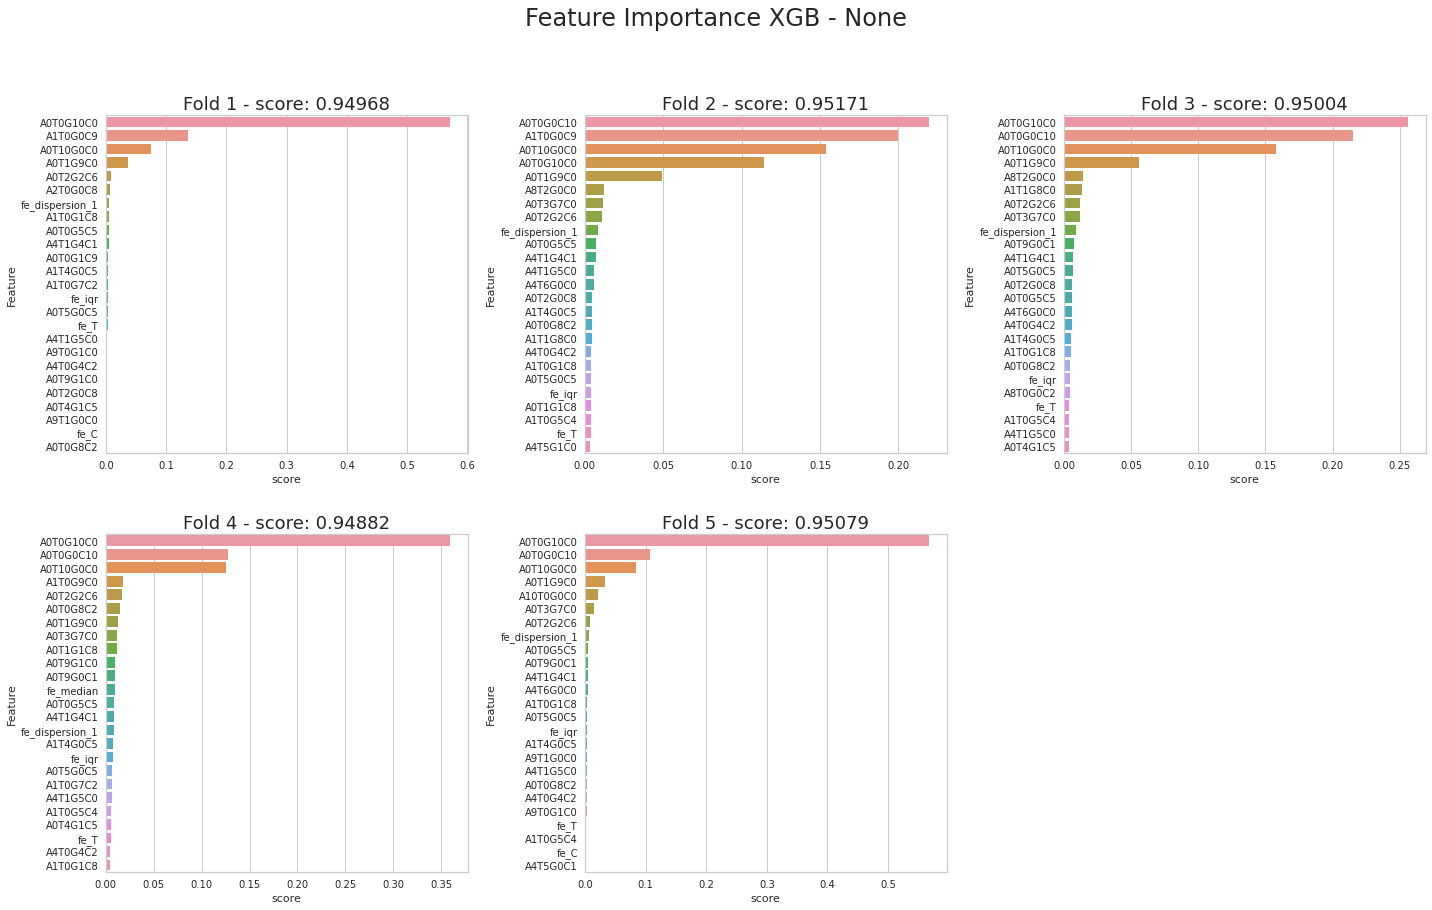

In [63]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

## 3.5. Clustering

In [64]:
df3_5_train = df3_4_train.copy()
df3_5_test  = df3_4_test.copy()

sc = StandardScaler()

df3_5_train_scaler = sc.fit_transform(df3_5_train[feature_float]) 
df3_5_test_scaler  = sc.transform(df3_5_test[feature_float]) 

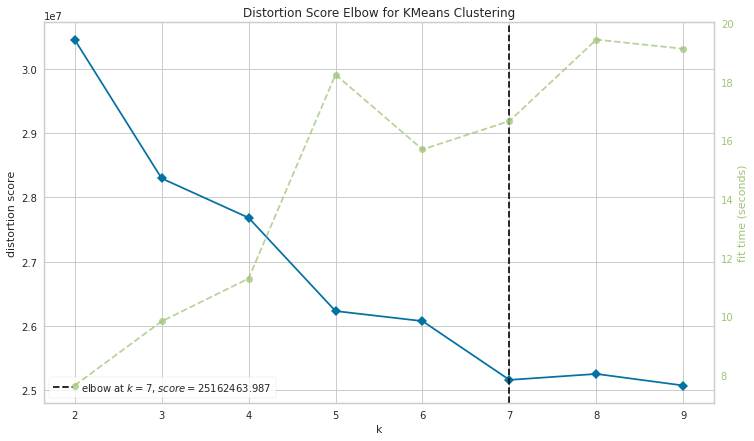

CPU times: user 3min 26s, sys: 17.7 s, total: 3min 44s
Wall time: 2min 2s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
%%time 
plt.figure(figsize=(12, 7))
visualizer_1 = KElbowVisualizer(KMeans(random_state=12359), k=(2,10))
visualizer_1.fit(df3_5_train_scaler)
visualizer_1.poof();

In [66]:
model_kmeans = KMeans(n_clusters=7, random_state=12359)
model_kmeans.fit(df3_5_train_scaler);

clusters_train = model_kmeans.predict(df3_5_train_scaler)
clusters_test  = model_kmeans.predict(df3_5_test_scaler)

df3_5_train['fe_cluster'] = clusters_train
df3_5_test['fe_cluster']  = clusters_test

#del df3_5_train_scaler, df3_5_test_scaler

df3_5_train.shape, df3_5_test.shape

((123993, 313), (100000, 311))

In [67]:
df3_5_train = pd.get_dummies(df3_5_train, columns=['fe_cluster'])
df3_5_test  = pd.get_dummies(df3_5_test, columns=['fe_cluster'])

df3_5_train.drop('fe_cluster_6', axis=1, inplace=True)
df3_5_test.drop('fe_cluster_6', axis=1, inplace=True)

df3_5_train.shape, df3_5_test.shape

((123993, 318), (100000, 316))

In [68]:
df3_5_train.filter(regex=r'fe').head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fe_mean          5 non-null      float16
 1   fe_std           5 non-null      float16
 2   fe_median        5 non-null      float16
 3   fe_var           5 non-null      float16
 4   fe_min           5 non-null      float16
 5   fe_max           5 non-null      float16
 6   fe_skew          5 non-null      float16
 7   fe_kurt          5 non-null      float16
 8   fe_quantile_25   5 non-null      float16
 9   fe_quantile_50   5 non-null      float16
 10  fe_quantile_75   5 non-null      float16
 11  fe_range         5 non-null      float16
 12  fe_iqr           5 non-null      float16
 13  fe_tails         5 non-null      float16
 14  fe_dispersion_1  5 non-null      float16
 15  fe_A             5 non-null      float16
 16  fe_T             5 non-null      float16
 17  fe_G             5 n

In [69]:
df3_5_train = reduce_memory_usage(df3_5_train)
df3_5_test  = reduce_memory_usage(df3_5_test)

Mem. usage decreased to 74.97 Mb (4.7% reduction)
Mem. usage decreased to 59.60 Mb (4.7% reduction)


In [70]:
missing_zero_values_table(df3_5_train)

Seu dataframe selecionado tem 318 colunas e 123993 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [71]:
jb.dump(df3_5_train, 'Data/pkl/df2_nb_02_train.pkl.z')
jb.dump(df3_5_test,  'Data/pkl/df2_nb_02_test.pkl.z')

gc.collect()

36362

# <div class="alert alert-success"> 6. Split Train/Test </div>

In [72]:
df6_train     = jb.load('Data/pkl/df2_nb_02_train.pkl.z')
df6_test      = jb.load('Data/pkl/df2_nb_02_test.pkl.z')

df6_train.shape, df6_test.shape

((123993, 318), (100000, 316))

In [73]:
lb     = LabelEncoder()
X      = df6_train.drop(target, axis=1)
y      = pd.DataFrame(lb.fit_transform(df6_train[target]), columns=[target])
X_test = df6_test

X.shape , X_test.shape

((123993, 317), (100000, 316))

# <div class="alert alert-success"> 7. Modelagem </div>

In [74]:
%%time 

seed_       = 12359
mdl         = []
df_trn_mdl  = []
df_fe_imp   = []
scaler_list = [None]

params = {"objective"    : 'multi:softmax',    
          'eval_metric'  : 'mlogloss',       
          'n_estimators' : 1000,
          'random_state' : seed_}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    
for sc in scaler_list:    
    model, df_trn, df_feature_imp, df_preds_prob = \
    model_train_cv_fit(model_        = xgb.XGBClassifier(**params),
                       model_name_   = 'xgb_fe_score_05F_{:2.5f}',
                       X_            = X,
                       y_            = y,
                       X_test_       = X_test,
                       lb_           = lb,
                       target_       = target,
                       sc_           = RobustScaler(), 
                       sc_second_    = sc,
                       n_splits_     = 5,
                       seed_         = seed_,
                       save_sub_     = True,
                       path_         = '', 
                      save_predict_  = True)

    mdl.append(model)
    df_trn_mdl.append(df_trn)
    df_fe_imp.append(df_feature_imp)

del model, df_trn, df_feature_imp

Scaler: None - n_estimators: 1000 
[Fold 1] ACC: 0.94713 - F1-macro: 0.97153 - Precision: 0.97156  - 0h 0m 47s
[Fold 2] ACC: 0.94968 - F1-macro: 0.97174 - Precision: 0.97177  - 0h 0m 50s
[Fold 3] ACC: 0.94783 - F1-macro: 0.97127 - Precision: 0.97129  - 0h 0m 52s
[Fold 4] ACC: 0.95141 - F1-macro: 0.97340 - Precision: 0.97340  - 0h 0m 49s
[Fold 5] ACC: 0.95037 - F1-macro: 0.97223 - Precision: 0.97225  - 0h 0m 47s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.94928 std: 0.00159 - 0h 4m 7s

CPU times: user 4min 13s, sys: 4.89 s, total: 4min 18s
Wall time: 4min 8s


<div class="alert alert-info" role="alert">
    
**`NOTA:`** <br>

    
</div>

## 7.1. Feature Importances  CV 

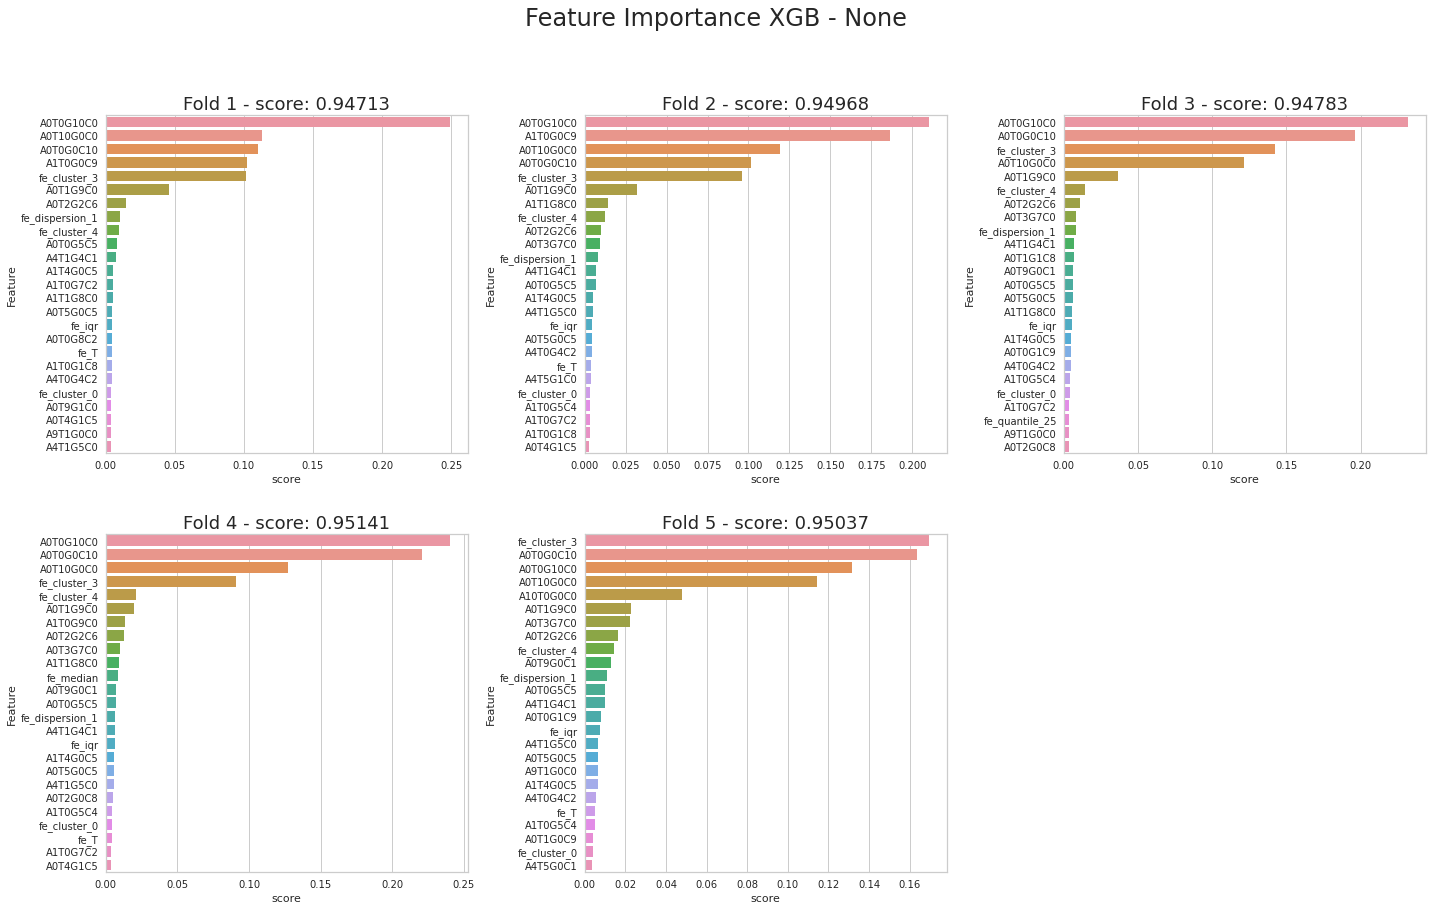

In [75]:
for i in range(len(df_trn_mdl)):
    plt.figure(figsize=(20,12))
    for fold, col in enumerate(df_trn_mdl[i].filter(regex=r'fold').columns):            
        col_acc = 'acc_' + str(fold+1)
        df_fi = df_trn_mdl[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
        df_fi = df_fi[['index', col, col_acc]]
        df_fi.columns = ['Feature', 'score', col_acc]
        plt.subplot(2,3, fold+1)
        sns.barplot(x='score', y='Feature', data=df_fi)    
        plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                  fontdict={'fontsize':18})    
    
    plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);   

# <div class="alert alert-success"> 5. Conclusão </div>

<div class="alert alert-info" role="alert">    
Neste notebook criamos novas variáveis utilizando a clusterização e variáveis estatísticas, com a finalidade de ajudar os modelos a identificar padrões no dados para melhora as previsões. <br>
    
<br> 
    

<br>
    
</div>